In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import numpy as np
import os
from torchvision.datasets import ImageFolder

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


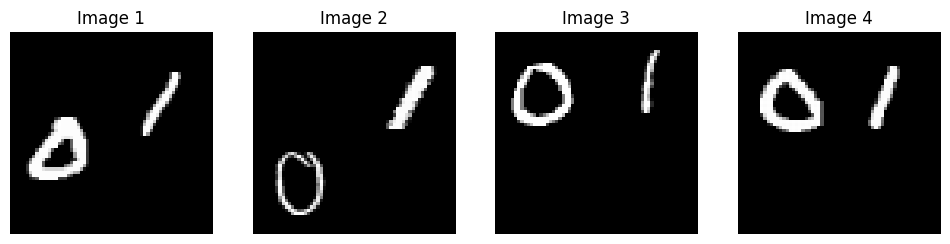

In [3]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread
root_directory = './double_mnist'
def display_images_from_folder(folder_path, num_images=4):
    image_files = os.listdir(folder_path)
    random_images = random.sample(image_files, num_images)
    
    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    plt.show()
train_folder = os.path.join(root_directory, 'train', '01') 
display_images_from_folder(train_folder)


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['03', '07', '10', '22', '27', '34', '39', '40', '48', '52', '58', '61', '64', '71', '93', '99']
tensor([38, 91, 16, 24, 23, 98, 54,  8,  1, 20, 35, 76, 60,  8,  5, 90,  5, 35,
        44, 19, 84, 24, 28, 95, 74, 50, 24, 26, 20, 94, 12, 13, 60, 69,

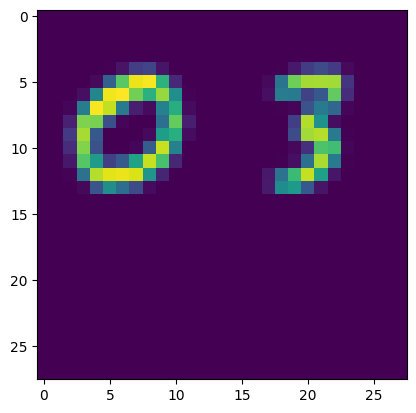

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import numpy as np
import os
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name) 
    
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
# Define batch sizes
batch_size = 64
print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = 10
class_names = train_dataset.classes
class_names = val_dataset.classes
print(class_names)
for images, labels in train_loader:
    print(labels)
    break
for images, labels in val_loader:
    plt.imshow(images[0].permute(1, 2, 0))
    print(labels[0])
    print(labels)
    break

# MLP On Double-MNIST

In [2]:
import torch
import torch.nn as nn

class MultiMNIST_MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate=0.5):
        super(MultiMNIST_MLP, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        layers = []
        layers.append(nn.Linear(input_size, hidden_neurons[0]))
        layers.append(nn.ReLU())
        for i in range(1, hidden_layers):
            layers.append(nn.Linear(hidden_neurons[i-1], hidden_neurons[i]))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_neurons[-1], num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [3]:
def train_model(model_left, model_right , train_loader, val_loader, criterion_left, optimizer_left, criterion_right, optimizer_right,num_epochs=5):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        # left half
        model_left.train()
        running_loss_left = 0.0
        correct_train_left = 0
        total_train_left = 0

        # right half
        model_right.train()
        running_loss_right = 0.0
        correct_train_right = 0
        total_train_right = 0

        for images, labels in train_loader:
            # left half
            labels_group_left = labels//10
            optimizer_left.zero_grad()
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            loss_left.backward()
            optimizer_left.step()
            running_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_train_left += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_left[k]==predicted_left[k]):
                    correct_train_left = correct_train_left+1
            # right half
            labels_group_right = labels % 10
            optimizer_right.zero_grad()
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            loss_right.backward()
            optimizer_right.step()
            running_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_train_right += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_right[k]==predicted_right[k]):
                    correct_train_right = correct_train_right+1


        train_accuracy = 100 * (correct_train_left+correct_train_right) / (total_train_left+total_train_right)
        train_losses.append((running_loss_right+running_loss_left) / (2*len(train_loader)))
        train_acc.append(train_accuracy)
        # left half
        model_left.eval()
        val_loss_left = 0.0
        correct_val_left = 0
        total_val_left = 0
        count_left = 0
        # right half
        model_right.eval()
        val_loss_right = 0.0
        correct_val_right = 0
        total_val_right = 0
        count_right = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # left half
                labels_group_left = labels // 10
                image_left = images.clone()
                left_half = images[:, :, :, :images.shape[3] // 2]
                image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
                outputs_left = model_left(image_left)
                loss_left = criterion_left(outputs_left, labels_group_left)
                val_loss_left += loss_left.item()
                _, predicted_left = torch.max(outputs_left.data, 1)
                total_val_left += labels.size(0)
                correct_val_left += (predicted_left == labels_group_left).sum().item()
                count_left = count_left+1
                # right half
                labels_group_right = labels % 10
                image_right = images.clone()
                right_half = images[:, :, :, images.shape[3] // 2:]
                image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
                outputs_right = model_right(image_right)
                loss_right = criterion_right(outputs_right, labels_group_right)
                val_loss_right += loss_right.item()
                _, predicted_right = torch.max(outputs_right.data, 1)
                total_val_right += labels.size(0)
                correct_val_right += (predicted_right == labels_group_right).sum().item()
                count_right = count_right+1

            val_accuracy = 100 * (correct_val_left+correct_val_right) / (total_val_left+total_val_right)
            val_losses.append((val_loss_left+val_loss_right) / (2*len(val_loader)))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc


def test_model(model_left, model_right , test_loader, criterion_left,criterion_right):
    # left half
    model_left.eval()
    test_loss_left = 0.0
    correct_test_left = 0
    total_test_left = 0
    count_left = 0
    # right half
    model_right.eval()
    test_loss_right = 0.0
    correct_test_right = 0
    total_test_right = 0
    count_right = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # left half
            labels_group_left = labels // 10
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            test_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_test_left += labels.size(0)
            correct_test_left += (predicted_left == labels_group_left).sum().item()
            count_left = count_left+1
            # right half
            labels_group_right = labels % 10
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            test_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_test_right += labels.size(0)
            correct_test_right += (predicted_right == labels_group_right).sum().item()
            count_right = count_right+1
        test_accuracy = 100 * (correct_test_left+correct_test_right) / (total_test_left+total_test_right)
        average_test_loss = ((test_loss_left+test_loss_right) / (2*len(test_loader)))

    print(f'Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    return test_accuracy


In [16]:
model_left = MultiMNIST_MLP(input_size=784,num_classes=num_classes,hidden_layers=3,hidden_neurons=[256,256,256])
model_right = MultiMNIST_MLP(input_size=784,num_classes=num_classes,hidden_layers=3,hidden_neurons=[256,256,256])
learning_rate = 0.001
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
train_losses, val_losses, train_acc, val_acc = train_model(model_left=model_left,model_right=model_right,train_loader=train_loader, val_loader=val_loader, criterion_left=criterion_left, optimizer_left=optimizer_left,criterion_right=criterion_right,optimizer_right=optimizer_right,num_epochs=5)
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Epoch 1/5, Train Loss: 1.9275, Train Acc: 30.43%, Val Loss: 1.7732, Val Acc: 33.94%
Epoch 2/5, Train Loss: 1.5415, Train Acc: 44.86%, Val Loss: 1.3347, Val Acc: 51.00%
Epoch 3/5, Train Loss: 1.1840, Train Acc: 58.19%, Val Loss: 0.9840, Val Acc: 65.37%
Epoch 4/5, Train Loss: 0.9346, Train Acc: 67.99%, Val Loss: 0.8256, Val Acc: 71.18%
Epoch 5/5, Train Loss: 0.7800, Train Acc: 73.84%, Val Loss: 0.6564, Val Acc: 77.78%
Test Loss: 0.7110, Test Acc: 76.04%


# Hyper-parameter tuning of MLP on Double-MNIST Dataset

In [4]:
import wandb
wandb.init(project="MLP on Double-MNIST Dataset")
sweep_config = {
    "method": "grid",
    "name": "MLP on Double-MNIST Dataset",
    "metric": {"goal": "maximize", "name": "test_accuracy"},
    "parameters": {
        "hidden_layers": {"values": [2,3]},
        "hidden_neurons_size": {"values": [128,256,512]},
    },
}
criterion = nn.CrossEntropyLoss()
sweep_id = wandb.sweep(sweep_config, project="MLP on Double-MNIST Dataset")
def train():
    wandb.init(project="MLP on Double-MNIST Dataset")
    config = wandb.config
    hidden_layers = config.hidden_layers
    hidden_neurons_size = config.hidden_neurons_size
    hidden_neurons  = [hidden_neurons_size for _ in range(hidden_layers)]
    print(hidden_layers,hidden_neurons)
    model_left = MultiMNIST_MLP(input_size=784,num_classes=num_classes,hidden_layers=hidden_layers,hidden_neurons=hidden_neurons)
    model_right = MultiMNIST_MLP(input_size=784,num_classes=num_classes,hidden_layers=hidden_layers,hidden_neurons=hidden_neurons)
    learning_rate = 0.001
    criterion_left = nn.CrossEntropyLoss()
    optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
    criterion_right = nn.CrossEntropyLoss()
    optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
    train_losses, val_losses, train_acc, val_acc = train_model(model_left=model_left,model_right=model_right,train_loader=train_loader, val_loader=val_loader, criterion_left=criterion_left, optimizer_left=optimizer_left,criterion_right=criterion_right,optimizer_right=optimizer_right,num_epochs=10)
    criterion_left = nn.CrossEntropyLoss()
    optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
    criterion_right = nn.CrossEntropyLoss()
    optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
    test_accuracy = test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)
    wandb.log({"Trainset Loss":train_losses[-1],"Trainset Accuracy":train_acc[-1],"Validation set Loss":val_losses[-1],"val_accuracy":val_acc[-1],"test_accuracy":test_accuracy,"hidden_layers":hidden_layers,"Neurons":hidden_layers*hidden_neurons_size,"hidden_neurons_size":hidden_neurons_size})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: rohitgowlapalli01. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: my2u462u
Sweep URL: https://wandb.ai/rohitgowlapalli01/MLP%20on%20Double-MNIST%20Dataset/sweeps/my2u462u
<IPython.core.display.HTML object>


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: xfssg1mm with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons_size: 128
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2 [128, 128]


Exception in thread Exception in thread ChkStopThrNetStatThr:
Exception in thread :
Traceback (most recent call last):
IntMsgThrTraceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
:
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
Traceback (most recent call last):
      File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()self.run()

  File "/usr/lib/python3.8/threading.py", line 870, in run
      File "/usr/lib/python3.8/threading.py", line 870, in run
    self.run()self._target(*self._args, **self._kwargs)    

self._target(*self._args, **self._kwargs)  File "/usr/lib/python3.8/threading.py", line 870, in run
  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 285, in check_stop_status

  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 267, in check_network_status
    self._target(*self._args, **self._k

Epoch 1/10, Train Loss: 1.9643, Train Acc: 29.56%, Val Loss: 1.8675, Val Acc: 31.45%
Epoch 2/10, Train Loss: 1.7865, Train Acc: 36.18%, Val Loss: 1.8475, Val Acc: 31.95%
Epoch 3/10, Train Loss: 1.7172, Train Acc: 38.81%, Val Loss: 1.7438, Val Acc: 34.62%
Epoch 4/10, Train Loss: 1.6426, Train Acc: 41.40%, Val Loss: 1.5981, Val Acc: 39.90%
Epoch 5/10, Train Loss: 1.5766, Train Acc: 43.63%, Val Loss: 1.5575, Val Acc: 40.95%
Epoch 6/10, Train Loss: 1.5149, Train Acc: 45.92%, Val Loss: 1.4652, Val Acc: 45.97%
Epoch 7/10, Train Loss: 1.4628, Train Acc: 48.04%, Val Loss: 1.4114, Val Acc: 48.33%
Epoch 8/10, Train Loss: 1.4161, Train Acc: 49.90%, Val Loss: 1.3539, Val Acc: 50.70%
Epoch 9/10, Train Loss: 1.3829, Train Acc: 51.22%, Val Loss: 1.3149, Val Acc: 52.12%
Epoch 10/10, Train Loss: 1.3651, Train Acc: 51.87%, Val Loss: 1.3039, Val Acc: 52.85%
Test Loss: 1.4678, Test Acc: 45.08%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,256
Trainset Accuracy,51.87266
Trainset Loss,1.36509


wandb: Agent Starting Run: wffojuda with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons_size: 256
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2 [256, 256]
Epoch 1/10, Train Loss: 1.9158, Train Acc: 31.10%, Val Loss: 1.8940, Val Acc: 29.72%
Epoch 2/10, Train Loss: 1.6184, Train Acc: 42.42%, Val Loss: 1.4501, Val Acc: 46.80%
Epoch 3/10, Train Loss: 1.3628, Train Acc: 51.85%, Val Loss: 1.2390, Val Acc: 55.97%
Epoch 4/10, Train Loss: 1.1915, Train Acc: 58.74%, Val Loss: 1.0940, Val Acc: 61.79%
Epoch 5/10, Train Loss: 1.0566, Train Acc: 64.07%, Val Loss: 0.9402, Val Acc: 67.73%
Epoch 6/10, Train Loss: 0.9675, Train Acc: 67.27%, Val Loss: 0.8915, Val Acc: 70.39%
Epoch 7/10, Train Loss: 0.9124, Train Acc: 69.44%, Val Loss: 0.8327, Val Acc: 72.28%
Epoch 8/10, Train Loss: 0.8683, Train Acc: 70.97%, Val Loss: 0.7576, Val Acc: 75.03%
Epoch 9/10, Train Loss: 0.8370, Train Acc: 72.16%, Val Loss: 0.7573, Val Acc: 74.82%
Epoch 10/10, Train Loss: 0.8092, Train Acc: 73.12%, Val Loss: 0.7484, Val Acc: 75.23%
Test Loss: 0.8404, Test Acc: 71.77%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,512
Trainset Accuracy,73.12422
Trainset Loss,0.80915


wandb: Agent Starting Run: 05yrlm8n with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons_size: 512
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2 [512, 512]
Epoch 1/10, Train Loss: 1.8971, Train Acc: 31.74%, Val Loss: 1.7635, Val Acc: 36.01%
Epoch 2/10, Train Loss: 1.5137, Train Acc: 46.02%, Val Loss: 1.3146, Val Acc: 52.82%
Epoch 3/10, Train Loss: 1.2485, Train Acc: 56.25%, Val Loss: 1.1258, Val Acc: 60.98%
Epoch 4/10, Train Loss: 1.0632, Train Acc: 63.81%, Val Loss: 0.9758, Val Acc: 66.50%
Epoch 5/10, Train Loss: 0.9230, Train Acc: 68.94%, Val Loss: 0.8348, Val Acc: 72.19%
Epoch 6/10, Train Loss: 0.8407, Train Acc: 71.97%, Val Loss: 0.7455, Val Acc: 75.33%
Epoch 7/10, Train Loss: 0.7906, Train Acc: 73.84%, Val Loss: 0.6899, Val Acc: 77.25%
Epoch 8/10, Train Loss: 0.7451, Train Acc: 75.50%, Val Loss: 0.6349, Val Acc: 79.17%
Epoch 9/10, Train Loss: 0.7187, Train Acc: 76.35%, Val Loss: 0.5994, Val Acc: 81.00%
Epoch 10/10, Train Loss: 0.6913, Train Acc: 77.32%, Val Loss: 0.6157, Val Acc: 79.82%
Test Loss: 0.6655, Test Acc: 78.23%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,1024
Trainset Accuracy,77.31797
Trainset Loss,0.69128


wandb: Agent Starting Run: o2vp9bpc with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons_size: 128
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


3 [128, 128, 128]
Epoch 1/10, Train Loss: 1.9657, Train Acc: 29.23%, Val Loss: 1.8374, Val Acc: 30.63%
Epoch 2/10, Train Loss: 1.6890, Train Acc: 39.42%, Val Loss: 1.5833, Val Acc: 41.21%
Epoch 3/10, Train Loss: 1.4525, Train Acc: 47.76%, Val Loss: 1.3348, Val Acc: 49.35%
Epoch 4/10, Train Loss: 1.2929, Train Acc: 53.78%, Val Loss: 1.2380, Val Acc: 54.40%
Epoch 5/10, Train Loss: 1.1888, Train Acc: 58.11%, Val Loss: 1.1920, Val Acc: 56.36%
Epoch 6/10, Train Loss: 1.0988, Train Acc: 61.70%, Val Loss: 0.9980, Val Acc: 65.04%
Epoch 7/10, Train Loss: 1.0229, Train Acc: 64.82%, Val Loss: 0.9959, Val Acc: 65.03%
Epoch 8/10, Train Loss: 0.9575, Train Acc: 67.58%, Val Loss: 0.9174, Val Acc: 67.87%
Epoch 9/10, Train Loss: 0.8963, Train Acc: 69.73%, Val Loss: 0.7800, Val Acc: 73.48%
Epoch 10/10, Train Loss: 0.8504, Train Acc: 71.27%, Val Loss: 0.7430, Val Acc: 74.16%
Test Loss: 0.8324, Test Acc: 71.31%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,384
Trainset Accuracy,71.27031
Trainset Loss,0.85044


wandb: Agent Starting Run: kba9yqzz with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons_size: 256
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


3 [256, 256, 256]
Epoch 1/10, Train Loss: 1.9579, Train Acc: 29.02%, Val Loss: 1.8345, Val Acc: 31.51%
Epoch 2/10, Train Loss: 1.6069, Train Acc: 41.98%, Val Loss: 1.4070, Val Acc: 46.95%
Epoch 3/10, Train Loss: 1.3144, Train Acc: 52.71%, Val Loss: 1.1498, Val Acc: 58.16%
Epoch 4/10, Train Loss: 1.1102, Train Acc: 61.17%, Val Loss: 0.9679, Val Acc: 65.57%
Epoch 5/10, Train Loss: 0.9702, Train Acc: 66.49%, Val Loss: 0.9519, Val Acc: 66.56%
Epoch 6/10, Train Loss: 0.8670, Train Acc: 70.38%, Val Loss: 0.8241, Val Acc: 71.90%
Epoch 7/10, Train Loss: 0.7854, Train Acc: 73.54%, Val Loss: 0.7451, Val Acc: 74.41%
Epoch 8/10, Train Loss: 0.7237, Train Acc: 75.85%, Val Loss: 0.6763, Val Acc: 76.99%
Epoch 9/10, Train Loss: 0.6776, Train Acc: 77.42%, Val Loss: 0.7224, Val Acc: 75.79%
Epoch 10/10, Train Loss: 0.6394, Train Acc: 78.63%, Val Loss: 0.5947, Val Acc: 79.75%
Test Loss: 0.6410, Test Acc: 78.05%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,768
Trainset Accuracy,78.63359
Trainset Loss,0.63943


wandb: Agent Starting Run: 1c8b3qwr with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons_size: 512
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


3 [512, 512, 512]
Epoch 1/10, Train Loss: 1.9055, Train Acc: 31.08%, Val Loss: 1.7871, Val Acc: 34.09%
Epoch 2/10, Train Loss: 1.4561, Train Acc: 47.73%, Val Loss: 1.1790, Val Acc: 57.97%
Epoch 3/10, Train Loss: 1.0344, Train Acc: 64.15%, Val Loss: 0.8395, Val Acc: 71.18%
Epoch 4/10, Train Loss: 0.8054, Train Acc: 72.64%, Val Loss: 0.6875, Val Acc: 76.64%
Epoch 5/10, Train Loss: 0.6992, Train Acc: 76.46%, Val Loss: 0.6148, Val Acc: 79.15%
Epoch 6/10, Train Loss: 0.6282, Train Acc: 78.89%, Val Loss: 0.6271, Val Acc: 78.95%
Epoch 7/10, Train Loss: 0.5811, Train Acc: 80.68%, Val Loss: 0.5709, Val Acc: 80.91%
Epoch 8/10, Train Loss: 0.5372, Train Acc: 82.13%, Val Loss: 0.4581, Val Acc: 85.04%
Epoch 9/10, Train Loss: 0.5053, Train Acc: 83.15%, Val Loss: 0.5053, Val Acc: 83.30%
Epoch 10/10, Train Loss: 0.4781, Train Acc: 84.10%, Val Loss: 0.4554, Val Acc: 85.05%
Test Loss: 0.4956, Test Acc: 83.74%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,1536
Trainset Accuracy,84.09922
Trainset Loss,0.47812


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <function _WandbInit._pause_backend at 0x7f4f0b66a9d0> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

### MLP on MNIST Dataset

In [17]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
train_size = int(0.8 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
gen = torch.Generator().manual_seed(42)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Test Loss: 13.4032, Test Acc: 7.63%


# CNN on Double-MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import numpy as np
import os
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name) 
    
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
# Define batch sizes
batch_size = 64
print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = 10
class_names = train_dataset.classes
class_names = val_dataset.classes
# print(class_names)
# for images, labels in train_loader:
#     print(labels)
#     break
# for images, labels in val_loader:
#     plt.imshow(images[0].permute(1, 2, 0))
#     print(labels[0])
#     print(labels)
#     break

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [2]:
class MultiMNIST_CNN(nn.Module):
    def __init__(self, input_channels , num_classes , dropout_size=0.25, strides=2, kernel_size=3, pool_size=2):
        super(MultiMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MultiMNIST_CNN(input_channels=1,num_classes=num_classes)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [3]:
def train_model(model_left, model_right , train_loader, val_loader, criterion_left, optimizer_left, criterion_right, optimizer_right,num_epochs=5):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        # left half
        model_left.train()
        running_loss_left = 0.0
        correct_train_left = 0
        total_train_left = 0

        # right half
        model_right.train()
        running_loss_right = 0.0
        correct_train_right = 0
        total_train_right = 0

        for images, labels in train_loader:
            # left half
            labels_group_left = labels//10
            optimizer_left.zero_grad()
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            loss_left.backward()
            optimizer_left.step()
            running_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_train_left += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_left[k]==predicted_left[k]):
                    correct_train_left = correct_train_left+1
            # right half
            labels_group_right = labels % 10
            optimizer_right.zero_grad()
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            loss_right.backward()
            optimizer_right.step()
            running_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_train_right += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group_right[k]==predicted_right[k]):
                    correct_train_right = correct_train_right+1


        train_accuracy = 100 * (correct_train_left+correct_train_right) / (total_train_left+total_train_right)
        train_losses.append((running_loss_right+running_loss_left) / (2*len(train_loader)))
        train_acc.append(train_accuracy)
        # left half
        model_left.eval()
        val_loss_left = 0.0
        correct_val_left = 0
        total_val_left = 0
        count_left = 0
        # right half
        model_right.eval()
        val_loss_right = 0.0
        correct_val_right = 0
        total_val_right = 0
        count_right = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # left half
                labels_group_left = labels // 10
                image_left = images.clone()
                left_half = images[:, :, :, :images.shape[3] // 2]
                image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
                outputs_left = model_left(image_left)
                loss_left = criterion_left(outputs_left, labels_group_left)
                val_loss_left += loss_left.item()
                _, predicted_left = torch.max(outputs_left.data, 1)
                total_val_left += labels.size(0)
                correct_val_left += (predicted_left == labels_group_left).sum().item()
                count_left = count_left+1
                # right half
                labels_group_right = labels % 10
                image_right = images.clone()
                right_half = images[:, :, :, images.shape[3] // 2:]
                image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
                outputs_right = model_right(image_right)
                loss_right = criterion_right(outputs_right, labels_group_right)
                val_loss_right += loss_right.item()
                _, predicted_right = torch.max(outputs_right.data, 1)
                total_val_right += labels.size(0)
                correct_val_right += (predicted_right == labels_group_right).sum().item()
                count_right = count_right+1

            val_accuracy = 100 * (correct_val_left+correct_val_right) / (total_val_left+total_val_right)
            val_losses.append((val_loss_left+val_loss_right) / (2*len(val_loader)))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc


def test_model(model_left, model_right , test_loader, criterion_left,criterion_right):
    # left half
    model_left.eval()
    test_loss_left = 0.0
    correct_test_left = 0
    total_test_left = 0
    count_left = 0
    # right half
    model_right.eval()
    test_loss_right = 0.0
    correct_test_right = 0
    total_test_right = 0
    count_right = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # left half
            labels_group_left = labels // 10
            image_left = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image_left[:, :, :, (image_left.shape[3] // 2):] = left_half
            outputs_left = model_left(image_left)
            loss_left = criterion_left(outputs_left, labels_group_left)
            test_loss_left += loss_left.item()
            _, predicted_left = torch.max(outputs_left.data, 1)
            total_test_left += labels.size(0)
            correct_test_left += (predicted_left == labels_group_left).sum().item()
            count_left = count_left+1
            # right half
            labels_group_right = labels % 10
            image_right = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image_right[:, :, :, :(image_right.shape[3] // 2)] = right_half
            outputs_right = model_right(image_right)
            loss_right = criterion_right(outputs_right, labels_group_right)
            test_loss_right += loss_right.item()
            _, predicted_right = torch.max(outputs_right.data, 1)
            total_test_right += labels.size(0)
            correct_test_right += (predicted_right == labels_group_right).sum().item()
            count_right = count_right+1
        test_accuracy = 100 * (correct_test_left+correct_test_right) / (total_test_left+total_test_right)
        average_test_loss = ((test_loss_left+test_loss_right) / (2*len(test_loader)))

    print(f'Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    return test_accuracy


In [22]:
model_left = MultiMNIST_CNN(input_channels=1,num_classes=num_classes)
model_right = MultiMNIST_CNN(input_channels=1,num_classes=num_classes)
learning_rate = 0.001
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
train_losses, val_losses, train_acc, val_acc = train_model(model_left=model_left,model_right=model_right,train_loader=train_loader, val_loader=val_loader, criterion_left=criterion_left, optimizer_left=optimizer_left,criterion_right=criterion_right,optimizer_right=optimizer_right,num_epochs=5)
criterion_left = nn.CrossEntropyLoss()
optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
criterion_right = nn.CrossEntropyLoss()
optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Epoch 1/5, Train Loss: 0.6381, Train Acc: 79.06%, Val Loss: 0.2061, Val Acc: 93.80%
Epoch 2/5, Train Loss: 0.1895, Train Acc: 94.26%, Val Loss: 0.1347, Val Acc: 95.72%
Epoch 3/5, Train Loss: 0.1339, Train Acc: 95.98%, Val Loss: 0.1048, Val Acc: 96.67%
Epoch 4/5, Train Loss: 0.1039, Train Acc: 96.71%, Val Loss: 0.0937, Val Acc: 97.03%
Epoch 5/5, Train Loss: 0.0850, Train Acc: 97.32%, Val Loss: 0.0830, Val Acc: 97.51%
Test Loss: 0.0959, Test Acc: 97.14%


# Hyper-parameter tuning of CNN on Double-MNIST Dataset

In [4]:
import wandb
wandb.init(project="CNN on Double-MNIST Dataset")
sweep_config = {
    "method": "grid",
    "name": "CNN on Double-MNIST Dataset",
    "metric": {"goal": "maximize", "name": "test_accuracy"},
    "parameters": {
        "learning_rate": {"values": [0.001,0.01]},
        "kernel_size": {"values": [3,5]},
        "dropout_rate": {"values": [0.5,0.7]},
    },
}
criterion = nn.CrossEntropyLoss()
sweep_id = wandb.sweep(sweep_config, project="CNN on Double-MNIST Dataset")
def train():
    wandb.init(project="CNN on Double-MNIST Dataset")
    config = wandb.config
    learning_rate = config.learning_rate
    dropout_rate = config.dropout_rate
    kernel_size = config.kernel_size
    print(learning_rate,dropout_rate,kernel_size)
    model_left = MultiMNIST_CNN(input_channels=1,num_classes=num_classes,dropout_size=dropout_rate,kernel_size=kernel_size)
    model_right = MultiMNIST_CNN(input_channels=1,num_classes=num_classes,dropout_size=dropout_rate,kernel_size=kernel_size)
    criterion_left = nn.CrossEntropyLoss()
    optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
    criterion_right = nn.CrossEntropyLoss()
    optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
    train_losses, val_losses, train_acc, val_acc = train_model(model_left=model_left,model_right=model_right,train_loader=train_loader, val_loader=val_loader, criterion_left=criterion_left, optimizer_left=optimizer_left,criterion_right=criterion_right,optimizer_right=optimizer_right,num_epochs=5)
    criterion_left = nn.CrossEntropyLoss()
    optimizer_left = optim.Adam(model_left.parameters(), lr=learning_rate)
    criterion_right = nn.CrossEntropyLoss()
    optimizer_right = optim.Adam(model_right.parameters(), lr=learning_rate)
    test_accuracy = test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)
    wandb.log({"Trainset Loss":train_losses[-1],"Trainset Accuracy":train_acc[-1],"Validation set Loss":val_losses[-1],"val_accuracy":val_acc[-1],"test_accuracy":test_accuracy,"learning_rate":learning_rate,"dropout_rate":dropout_rate,"kernel_size":kernel_size})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: rohitgowlapalli01. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 4caacuwc
Sweep URL: https://wandb.ai/rohitgowlapalli01/CNN%20on%20Double-MNIST%20Dataset/sweeps/4caacuwc
<IPython.core.display.HTML object>


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: kjavbwsj with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.5 3


Exception in thread Exception in thread IntMsgThrChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    :
self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
Traceback (most recent call last):
Exception in thread   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    NetStatThrself._target(*self._args, **self._kwargs):
    
Traceback (most recent call last):
self.run()  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 299, in check_internal_messages
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner

  File "/usr/lib/python3.8/threading.py", line 870, in run
    self.run()
      File "/usr/lib/python3.8/threading.py", line 870, in run
self._loop_check_status(    
    self._target(*self._args, **self._kwargs)  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 223, in _loop_check_status
sel

Epoch 1/5, Train Loss: 0.8050, Train Acc: 72.87%, Val Loss: 0.2296, Val Acc: 93.38%
Epoch 2/5, Train Loss: 0.2814, Train Acc: 91.68%, Val Loss: 0.1455, Val Acc: 95.72%
Epoch 3/5, Train Loss: 0.2046, Train Acc: 93.88%, Val Loss: 0.1138, Val Acc: 96.46%
Epoch 4/5, Train Loss: 0.1611, Train Acc: 95.19%, Val Loss: 0.1042, Val Acc: 96.80%
Epoch 5/5, Train Loss: 0.1346, Train Acc: 95.93%, Val Loss: 0.0937, Val Acc: 97.15%
Test Loss: 0.0949, Test Acc: 97.17%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,95.92812
Trainset Loss,0.13462
Validation set Loss,0.09374


wandb: Agent Starting Run: aioafykn with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.5 3
Epoch 1/5, Train Loss: 0.9555, Train Acc: 67.63%, Val Loss: 0.5349, Val Acc: 82.96%
Epoch 2/5, Train Loss: 0.5875, Train Acc: 81.74%, Val Loss: 0.4571, Val Acc: 85.85%
Epoch 3/5, Train Loss: 0.5355, Train Acc: 83.68%, Val Loss: 0.4489, Val Acc: 86.51%
Epoch 4/5, Train Loss: 0.5091, Train Acc: 84.49%, Val Loss: 0.4413, Val Acc: 86.74%
Epoch 5/5, Train Loss: 0.4997, Train Acc: 84.95%, Val Loss: 0.4210, Val Acc: 87.89%
Test Loss: 0.4314, Test Acc: 87.17%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,84.94844
Trainset Loss,0.49967
Validation set Loss,0.42103


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5wtvr7rq with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.5 5
Epoch 1/5, Train Loss: 0.7031, Train Acc: 76.67%, Val Loss: 0.1955, Val Acc: 94.32%
Epoch 2/5, Train Loss: 0.2239, Train Acc: 93.51%, Val Loss: 0.1140, Val Acc: 96.63%
Epoch 3/5, Train Loss: 0.1533, Train Acc: 95.53%, Val Loss: 0.1029, Val Acc: 96.87%
Epoch 4/5, Train Loss: 0.1175, Train Acc: 96.52%, Val Loss: 0.0951, Val Acc: 97.03%
Epoch 5/5, Train Loss: 0.0947, Train Acc: 97.21%, Val Loss: 0.0813, Val Acc: 97.49%
Test Loss: 0.0829, Test Acc: 97.48%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,97.21406
Trainset Loss,0.09475
Validation set Loss,0.08127


wandb: Agent Starting Run: i9wb71ip with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.5 5
Epoch 1/5, Train Loss: 0.4948, Train Acc: 84.98%, Val Loss: 0.2312, Val Acc: 93.75%
Epoch 2/5, Train Loss: 0.2939, Train Acc: 92.06%, Val Loss: 0.2404, Val Acc: 93.42%
Epoch 3/5, Train Loss: 0.2831, Train Acc: 92.41%, Val Loss: 0.1845, Val Acc: 95.16%
Epoch 4/5, Train Loss: 0.2865, Train Acc: 92.66%, Val Loss: 0.2043, Val Acc: 94.94%
Epoch 5/5, Train Loss: 0.2936, Train Acc: 92.61%, Val Loss: 0.2606, Val Acc: 93.33%
Test Loss: 0.2492, Test Acc: 93.47%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,92.61328
Trainset Loss,0.29355
Validation set Loss,0.26058


wandb: Agent Starting Run: 0e92miqf with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.7 3
Epoch 1/5, Train Loss: 0.9772, Train Acc: 66.29%, Val Loss: 0.2796, Val Acc: 91.81%
Epoch 2/5, Train Loss: 0.4011, Train Acc: 87.54%, Val Loss: 0.1674, Val Acc: 95.10%
Epoch 3/5, Train Loss: 0.2889, Train Acc: 91.21%, Val Loss: 0.1471, Val Acc: 95.62%
Epoch 4/5, Train Loss: 0.2375, Train Acc: 92.72%, Val Loss: 0.1022, Val Acc: 96.98%
Epoch 5/5, Train Loss: 0.2011, Train Acc: 93.85%, Val Loss: 0.1076, Val Acc: 96.78%
Test Loss: 0.1167, Test Acc: 96.45%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,93.84922
Trainset Loss,0.20114
Validation set Loss,0.10758


wandb: Agent Starting Run: 5siybr8q with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.7 3
Epoch 1/5, Train Loss: 1.1903, Train Acc: 59.06%, Val Loss: 0.6289, Val Acc: 80.78%
Epoch 2/5, Train Loss: 0.8539, Train Acc: 72.28%, Val Loss: 0.5543, Val Acc: 83.32%
Epoch 3/5, Train Loss: 0.7984, Train Acc: 74.42%, Val Loss: 0.5234, Val Acc: 84.75%
Epoch 4/5, Train Loss: 0.7755, Train Acc: 75.46%, Val Loss: 0.5121, Val Acc: 85.47%
Epoch 5/5, Train Loss: 0.7545, Train Acc: 76.19%, Val Loss: 0.5171, Val Acc: 85.27%
Test Loss: 0.5782, Test Acc: 82.51%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,76.18594
Trainset Loss,0.75454
Validation set Loss,0.51709


wandb: Agent Starting Run: n7mzjxc1 with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.7 5
Epoch 1/5, Train Loss: 0.8782, Train Acc: 70.34%, Val Loss: 0.2418, Val Acc: 93.11%
Epoch 2/5, Train Loss: 0.3238, Train Acc: 90.45%, Val Loss: 0.1466, Val Acc: 95.60%
Epoch 3/5, Train Loss: 0.2227, Train Acc: 93.49%, Val Loss: 0.1279, Val Acc: 96.35%
Epoch 4/5, Train Loss: 0.1773, Train Acc: 94.91%, Val Loss: 0.1012, Val Acc: 97.03%
Epoch 5/5, Train Loss: 0.1437, Train Acc: 95.91%, Val Loss: 0.0899, Val Acc: 97.39%
Test Loss: 0.0960, Test Acc: 97.25%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,95.91016
Trainset Loss,0.14369
Validation set Loss,0.08989


wandb: Agent Starting Run: j0db45vm with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.7 5
Epoch 1/5, Train Loss: 0.7090, Train Acc: 77.60%, Val Loss: 0.2750, Val Acc: 92.86%
Epoch 2/5, Train Loss: 0.4416, Train Acc: 87.89%, Val Loss: 0.2990, Val Acc: 91.79%
Epoch 3/5, Train Loss: 0.4157, Train Acc: 88.72%, Val Loss: 0.3480, Val Acc: 92.61%
Epoch 4/5, Train Loss: 0.3926, Train Acc: 89.56%, Val Loss: 0.2825, Val Acc: 93.53%
Epoch 5/5, Train Loss: 0.3947, Train Acc: 89.61%, Val Loss: 0.2571, Val Acc: 93.84%
Test Loss: 0.2813, Test Acc: 93.25%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,89.60547
Trainset Loss,0.39467
Validation set Loss,0.25708


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <function _WandbInit._pause_backend at 0x7f3baeb98a60> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

# CNN ON MNIST Dataset

In [27]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
train_size = int(0.8 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
gen = torch.Generator().manual_seed(42)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_model(model_left=model_left,model_right=model_right,test_loader=test_loader,criterion_left=criterion_left,criterion_right=criterion_right)

Test Loss: 16.8805, Test Acc: 4.98%


# Permuted MNIST

In [2]:
# To load the dataset, you can use np.load
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]

In [3]:
x_train, x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.1, random_state=42)


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Convert NumPy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()
permuted_x_test = torch.from_numpy(permuted_x_test).float()
y_test = torch.from_numpy(y_test).long()


batch_size = 64
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(permuted_x_test, y_test), batch_size=batch_size, shuffle=False)


# MLP on Permuted MNIST

In [4]:
import torch
import torch.nn as nn

class PermutedMNIST_MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers, hidden_neurons, dropout_rate=0.5):
        super(PermutedMNIST_MLP, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        layers = []
        layers.append(nn.Linear(input_size, hidden_neurons[0]))
        layers.append(nn.ReLU())
        for i in range(1, hidden_layers):
            layers.append(nn.Linear(hidden_neurons[i-1], hidden_neurons[i]))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_neurons[-1], num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc 


def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_loss = (test_loss / len(test_loader))

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    return test_accuracy

In [43]:
model = PermutedMNIST_MLP(input_size=784,num_classes=10,hidden_layers=3,hidden_neurons=[256,256,256])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_acc, val_acc = train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=10)
test_model(model=model,test_loader=test_loader,criterion=criterion)

Epoch 1/10, Train Loss: 0.3411, Train Acc: 90.57%, Val Loss: 0.1508, Val Acc: 95.48%
Epoch 2/10, Train Loss: 0.1698, Train Acc: 95.30%, Val Loss: 0.1237, Val Acc: 96.53%
Epoch 3/10, Train Loss: 0.1409, Train Acc: 96.19%, Val Loss: 0.1440, Val Acc: 96.48%
Epoch 4/10, Train Loss: 0.1285, Train Acc: 96.57%, Val Loss: 0.1371, Val Acc: 96.73%
Epoch 5/10, Train Loss: 0.1085, Train Acc: 97.21%, Val Loss: 0.1222, Val Acc: 97.30%
Epoch 6/10, Train Loss: 0.1064, Train Acc: 97.24%, Val Loss: 0.1393, Val Acc: 96.82%
Epoch 7/10, Train Loss: 0.0950, Train Acc: 97.57%, Val Loss: 0.1415, Val Acc: 97.12%
Epoch 8/10, Train Loss: 0.0930, Train Acc: 97.70%, Val Loss: 0.1379, Val Acc: 97.22%
Epoch 9/10, Train Loss: 0.0906, Train Acc: 97.74%, Val Loss: 0.1447, Val Acc: 97.32%
Epoch 10/10, Train Loss: 0.0866, Train Acc: 97.88%, Val Loss: 0.1291, Val Acc: 97.40%
Test Loss: 0.1481, Test Acc: 97.16%


# Hyper-parameter tuning of MLP on Permuted MNIST

In [6]:
import wandb
wandb.init(project="MLP on Permuted-MNIST Dataset")
sweep_config = {
    "method": "grid",
    "name": "MLP on Permuted-MNIST Dataset",
    "metric": {"goal": "maximize", "name": "test_accuracy"},
    "parameters": {
        "hidden_layers": {"values": [2,3]},
        "hidden_neurons_size": {"values": [128,256,512]},
    },
}
criterion = nn.CrossEntropyLoss()
sweep_id = wandb.sweep(sweep_config, project="MLP on Permuted-MNIST Dataset")
def train():
    wandb.init(project="MLP on Permuted-MNIST Dataset")
    config = wandb.config
    hidden_layers = config.hidden_layers
    hidden_neurons_size = config.hidden_neurons_size
    hidden_neurons  = [hidden_neurons_size for _ in range(hidden_layers)]
    model = PermutedMNIST_MLP(input_size=784,num_classes=10,hidden_layers=hidden_layers,hidden_neurons=hidden_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses, train_acc, val_acc = train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=3)
    test_accuracy = test_model(model=model,test_loader=test_loader,criterion=criterion)
    wandb.log({"Trainset Loss":train_losses[-1],"Trainset Accuracy":train_acc[-1],"Validation set Loss":val_losses[-1],"val_accuracy":val_acc[-1],"test_accuracy":test_accuracy,"hidden_layers":hidden_layers,"Neurons":hidden_layers*hidden_neurons_size,"hidden_neurons_size":hidden_neurons_size})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: rohitgowlapalli01. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: itntkdo9
Sweep URL: https://wandb.ai/rohitgowlapalli01/MLP%20on%20Permuted-MNIST%20Dataset/sweeps/itntkdo9
<IPython.core.display.HTML object>


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: biuq10ad with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons_size: 128
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Exception in thread Exception in thread NetStatThrException in thread IntMsgThr:
Traceback (most recent call last):
:
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
ChkStopThrTraceback (most recent call last):
:
      File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
Traceback (most recent call last):
self.run()  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner

      File "/usr/lib/python3.8/threading.py", line 870, in run
self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
        self._target(*self._args, **self._kwargs)    self.run()
self._target(*self._args, **self._kwargs)
  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 267, in check_network_status

  File "/usr/lib/python3.8/threading.py", line 870, in run
      File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 299, in check_internal_messages
    self._loop_check_status(s

Epoch 1/3, Train Loss: 0.5344, Train Acc: 86.07%, Val Loss: 0.2514, Val Acc: 93.00%
Epoch 2/3, Train Loss: 0.2556, Train Acc: 92.93%, Val Loss: 0.1518, Val Acc: 95.65%
Epoch 3/3, Train Loss: 0.2106, Train Acc: 94.12%, Val Loss: 0.1419, Val Acc: 95.93%
Test Loss: 0.1404, Test Acc: 95.88%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,256
Trainset Accuracy,94.12222
Trainset Loss,0.2106


wandb: Agent Starting Run: n5zjfcl1 with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons_size: 256
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/3, Train Loss: 0.4799, Train Acc: 88.51%, Val Loss: 0.1518, Val Acc: 95.38%
Epoch 2/3, Train Loss: 0.2203, Train Acc: 93.79%, Val Loss: 0.1519, Val Acc: 95.32%
Epoch 3/3, Train Loss: 0.1911, Train Acc: 94.79%, Val Loss: 0.1536, Val Acc: 95.60%
Test Loss: 0.1482, Test Acc: 95.74%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,512
Trainset Accuracy,94.79074
Trainset Loss,0.19113


wandb: Agent Starting Run: xom6utg1 with config:
wandb: 	hidden_layers: 2
wandb: 	hidden_neurons_size: 512
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/3, Train Loss: 0.4685, Train Acc: 89.97%, Val Loss: 0.1720, Val Acc: 95.07%
Epoch 2/3, Train Loss: 0.2149, Train Acc: 94.28%, Val Loss: 0.1466, Val Acc: 95.98%
Epoch 3/3, Train Loss: 0.1931, Train Acc: 95.01%, Val Loss: 0.1720, Val Acc: 95.73%
Test Loss: 0.1884, Test Acc: 95.16%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,1024
Trainset Accuracy,95.01111
Trainset Loss,0.1931


wandb: Agent Starting Run: ryh9xz8o with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons_size: 128
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/3, Train Loss: 0.3942, Train Acc: 88.95%, Val Loss: 0.1598, Val Acc: 95.03%
Epoch 2/3, Train Loss: 0.1867, Train Acc: 94.86%, Val Loss: 0.1555, Val Acc: 95.50%
Epoch 3/3, Train Loss: 0.1438, Train Acc: 96.01%, Val Loss: 0.1242, Val Acc: 96.33%
Test Loss: 0.1113, Test Acc: 96.55%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,384
Trainset Accuracy,96.01481
Trainset Loss,0.14384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 097zpjmj with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons_size: 256
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/3, Train Loss: 0.3292, Train Acc: 90.66%, Val Loss: 0.1688, Val Acc: 95.00%
Epoch 2/3, Train Loss: 0.1680, Train Acc: 95.43%, Val Loss: 0.1345, Val Acc: 96.20%
Epoch 3/3, Train Loss: 0.1380, Train Acc: 96.21%, Val Loss: 0.1374, Val Acc: 96.30%
Test Loss: 0.1351, Test Acc: 96.25%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,768
Trainset Accuracy,96.20926
Trainset Loss,0.13805


wandb: Agent Starting Run: cnasj851 with config:
wandb: 	hidden_layers: 3
wandb: 	hidden_neurons_size: 512
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/3, Train Loss: 0.3141, Train Acc: 91.53%, Val Loss: 0.1918, Val Acc: 95.00%
Epoch 2/3, Train Loss: 0.1713, Train Acc: 95.33%, Val Loss: 0.1252, Val Acc: 96.55%
Epoch 3/3, Train Loss: 0.1475, Train Acc: 96.24%, Val Loss: 0.1406, Val Acc: 96.48%
Test Loss: 0.1465, Test Acc: 96.61%


Neurons,▁
Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
hidden_layers,▁
hidden_neurons_size,▁
test_accuracy,▁
val_accuracy,▁
Neurons,1536
Trainset Accuracy,96.23519
Trainset Loss,0.14749


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <function _WandbInit._pause_backend at 0x7f21a2efc790> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

# CNN On Permuted MNIST

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]
x_train, x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.1, random_state=42)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Convert NumPy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()
permuted_x_test = torch.from_numpy(permuted_x_test).float()
y_test = torch.from_numpy(y_test).long()
batch_size = 64
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(permuted_x_test, y_test), batch_size=batch_size, shuffle=False)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report

class CNN(nn.Module):
    def __init__(self, dropout_size=0.25, strides=2, kernel_size=3,pool_size = 2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size,stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1,64*self.dim*self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.unsqueeze(1))
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc 


def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_loss = (test_loss / len(test_loader))

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    return test_accuracy

In [69]:
model = CNN(dropout_size=0.25, strides=2, kernel_size=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_acc, val_acc  = train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=5)
test_model(model=model,test_loader=test_loader,criterion=criterion)

Epoch 1/5, Train Loss: 0.5713, Train Acc: 85.54%, Val Loss: 0.2277, Val Acc: 92.63%
Epoch 2/5, Train Loss: 0.2320, Train Acc: 92.82%, Val Loss: 0.1914, Val Acc: 94.08%
Epoch 3/5, Train Loss: 0.1858, Train Acc: 94.20%, Val Loss: 0.1637, Val Acc: 94.98%
Epoch 4/5, Train Loss: 0.1575, Train Acc: 94.96%, Val Loss: 0.1865, Val Acc: 94.33%
Epoch 5/5, Train Loss: 0.1429, Train Acc: 95.39%, Val Loss: 0.1510, Val Acc: 95.72%
Test Loss: 0.1547, Test Acc: 95.37%


In [5]:
import wandb
wandb.init(project="CNN on Permuted-MNIST Dataset")
sweep_config = {
    "method": "grid",
    "name": "CNN on Permuted-MNIST Dataset",
    "metric": {"goal": "maximize", "name": "test_accuracy"},
    "parameters": { 
        "learning_rate": {"values": [0.001,0.01]},
        "kernel_size": {"values": [3,5]},
        "dropout_rate": {"values": [0.5,0.7]},
    },
}
criterion = nn.CrossEntropyLoss()
sweep_id = wandb.sweep(sweep_config, project="CNN on Permuted-MNIST Dataset")
def train():
    wandb.init(project="CNN on Permuted-MNIST Dataset")
    config = wandb.config
    learning_rate = config.learning_rate
    dropout_rate = config.dropout_rate
    kernel_size = config.kernel_size
    print(learning_rate,dropout_rate,kernel_size)
    model = CNN(dropout_size=dropout_rate, strides=2, kernel_size=kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_acc, val_acc  = train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=4)
    test_accuracy = test_model(model=model,test_loader=test_loader,criterion=criterion)
    wandb.log({"Trainset Loss":train_losses[-1],"Trainset Accuracy":train_acc[-1],"Validation set Loss":val_losses[-1],"val_accuracy":val_acc[-1],"test_accuracy":test_accuracy,"learning_rate":learning_rate,"dropout_rate":dropout_rate,"kernel_size":kernel_size})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: rohitgowlapalli01. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: c2arw9m2
Sweep URL: https://wandb.ai/rohitgowlapalli01/CNN%20on%20Permuted-MNIST%20Dataset/sweeps/c2arw9m2
<IPython.core.display.HTML object>


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: wx73ej5y with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.5 3


Exception in thread ChkStopThrException in thread Exception in thread :
IntMsgThrNetStatThrTraceback (most recent call last):
:
:
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()Traceback (most recent call last):
self.run()
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
  File "/usr/lib/python3.8/threading.py", line 870, in run
    
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 299, in check_internal_messages
    self._loop_check_status(
  File "/home/rohit172/.local/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 223, in _loop_check_status
    lo

Epoch 1/4, Train Loss: 0.8326, Train Acc: 81.30%, Val Loss: 0.2464, Val Acc: 92.40%
Epoch 2/4, Train Loss: 0.3222, Train Acc: 89.99%, Val Loss: 0.2162, Val Acc: 93.20%
Epoch 3/4, Train Loss: 0.2703, Train Acc: 91.59%, Val Loss: 0.1888, Val Acc: 93.92%
Epoch 4/4, Train Loss: 0.2394, Train Acc: 92.54%, Val Loss: 0.1878, Val Acc: 94.48%
Test Loss: 0.1859, Test Acc: 94.13%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,92.53889
Trainset Loss,0.23941
Validation set Loss,0.18782


wandb: Agent Starting Run: wusvxtd4 with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.5 3
Epoch 1/4, Train Loss: 1.9613, Train Acc: 58.20%, Val Loss: 0.8248, Val Acc: 74.62%
Epoch 2/4, Train Loss: 1.0390, Train Acc: 67.52%, Val Loss: 0.7719, Val Acc: 76.12%
Epoch 3/4, Train Loss: 0.9860, Train Acc: 69.49%, Val Loss: 0.7755, Val Acc: 77.53%
Epoch 4/4, Train Loss: 0.9649, Train Acc: 70.26%, Val Loss: 0.6629, Val Acc: 79.92%
Test Loss: 0.6307, Test Acc: 81.00%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,70.25741
Trainset Loss,0.96487
Validation set Loss,0.66291


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzw1iz5g with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.5 5
Epoch 1/4, Train Loss: 0.6882, Train Acc: 80.46%, Val Loss: 0.3122, Val Acc: 90.52%
Epoch 2/4, Train Loss: 0.3333, Train Acc: 89.86%, Val Loss: 0.2686, Val Acc: 91.30%
Epoch 3/4, Train Loss: 0.2857, Train Acc: 91.30%, Val Loss: 0.2238, Val Acc: 93.52%
Epoch 4/4, Train Loss: 0.2615, Train Acc: 91.95%, Val Loss: 0.1954, Val Acc: 94.35%
Test Loss: 0.1844, Test Acc: 94.54%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,91.94815
Trainset Loss,0.26151
Validation set Loss,0.19537


wandb: Agent Starting Run: 5bm1hn0u with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.5 5
Epoch 1/4, Train Loss: 3.3654, Train Acc: 27.79%, Val Loss: 1.5174, Val Acc: 42.40%
Epoch 2/4, Train Loss: 1.6372, Train Acc: 40.08%, Val Loss: 1.3445, Val Acc: 50.05%
Epoch 3/4, Train Loss: 1.6185, Train Acc: 42.02%, Val Loss: 1.4443, Val Acc: 49.42%
Epoch 4/4, Train Loss: 1.7894, Train Acc: 37.29%, Val Loss: 1.9727, Val Acc: 26.08%
Test Loss: 1.9500, Test Acc: 26.71%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,37.29074
Trainset Loss,1.78938
Validation set Loss,1.9727


wandb: Agent Starting Run: qbyo703q with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.7 3
Epoch 1/4, Train Loss: 1.1022, Train Acc: 66.64%, Val Loss: 0.3005, Val Acc: 90.70%
Epoch 2/4, Train Loss: 0.6265, Train Acc: 78.65%, Val Loss: 0.2500, Val Acc: 92.67%
Epoch 3/4, Train Loss: 0.5276, Train Acc: 82.19%, Val Loss: 0.2362, Val Acc: 92.83%
Epoch 4/4, Train Loss: 0.4668, Train Acc: 84.61%, Val Loss: 0.2029, Val Acc: 94.00%
Test Loss: 0.2086, Test Acc: 93.63%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,84.61481
Trainset Loss,0.46678
Validation set Loss,0.20288


wandb: Agent Starting Run: 95fb0w3x with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.7 3
Epoch 1/4, Train Loss: 2.5024, Train Acc: 24.04%, Val Loss: 1.8770, Val Acc: 29.67%
Epoch 2/4, Train Loss: 1.8957, Train Acc: 31.51%, Val Loss: 1.6642, Val Acc: 40.72%
Epoch 3/4, Train Loss: 1.7339, Train Acc: 38.99%, Val Loss: 1.4995, Val Acc: 48.27%
Epoch 4/4, Train Loss: 1.5641, Train Acc: 45.80%, Val Loss: 1.2401, Val Acc: 58.50%
Test Loss: 1.2096, Test Acc: 59.58%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,45.79815
Trainset Loss,1.56412
Validation set Loss,1.2401


wandb: Agent Starting Run: 35m0udam with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001 0.7 5
Epoch 1/4, Train Loss: 0.8626, Train Acc: 74.30%, Val Loss: 0.3451, Val Acc: 89.37%
Epoch 2/4, Train Loss: 0.4173, Train Acc: 87.56%, Val Loss: 0.2453, Val Acc: 92.38%
Epoch 3/4, Train Loss: 0.3630, Train Acc: 89.10%, Val Loss: 0.2305, Val Acc: 92.98%
Epoch 4/4, Train Loss: 0.3273, Train Acc: 90.23%, Val Loss: 0.2130, Val Acc: 93.20%
Test Loss: 0.2109, Test Acc: 93.46%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,90.22593
Trainset Loss,0.32728
Validation set Loss,0.213


wandb: Agent Starting Run: cna5cqrw with config:
wandb: 	dropout_rate: 0.7
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01 0.7 5
Epoch 1/4, Train Loss: 3.6493, Train Acc: 18.51%, Val Loss: 2.0167, Val Acc: 21.97%
Epoch 2/4, Train Loss: 2.0178, Train Acc: 22.74%, Val Loss: 1.9728, Val Acc: 24.18%
Epoch 3/4, Train Loss: 2.0880, Train Acc: 21.41%, Val Loss: 2.0017, Val Acc: 26.38%
Epoch 4/4, Train Loss: 2.2425, Train Acc: 16.14%, Val Loss: 2.2713, Val Acc: 15.27%
Test Loss: 2.2701, Test Acc: 15.45%


Trainset Accuracy,▁
Trainset Loss,▁
Validation set Loss,▁
dropout_rate,▁
kernel_size,▁
learning_rate,▁
test_accuracy,▁
val_accuracy,▁
Trainset Accuracy,16.13519
Trainset Loss,2.2425
Validation set Loss,2.27131


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <function _WandbInit._pause_backend at 0x7f0a1adb1a60> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe